# Abstract-art gallery
Michal Skaličan, Lucia Ondovčíková

In [5]:
!pip install cleanvision
from cleanvision.imagelab import Imagelab
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb
import time

You should consider upgrading via the 'C:\Users\micha\Documents\zadanie3\venv\Scripts\python.exe -m pip install --upgrade pip' command.


# Analýza datasetu
Dataset zahŕňa 2782 súborov abstraktného umenia, v rôznych formátoch. Obrázky nie sú prerozdelené, všetky sú v jednom priečinku.
Link na dataset: https://www.kaggle.com/datasets/bryanb/abstract-art-gallery

Kaggle poskytuje bezplatný prístup k GPU NVidia K80, preto rozhodli sme sa trénovať model tam.

Pre analýzu datasetu sme použili existujúcu knižnicu Cleanvision, ktorú bolo potrebné doinštalovať. 
Slúži na automatickú detekciu rôznych problémov v obrazových súboroch, ako napr. duplikácia, rozmazanosť, pre/pod-exponovanie obrázkov atď.
Pomocou funkcie imagelab.report() si dané problémy vieme veľmi rýchlo prezrieť a zanalyzovať.

In [ ]:
#!cp -r '/kaggle/input/abstract-art-gallery' './abstract'
#!wandb login

Ako prvé si načítame dataset a vizualizujeme pár obrázkov, aby sme mali cca prehľad, o čo sa jedná. Následne pomocou find_issues() nájdeme potencionállne problémy a necháme si vypísať report.

Reading images from C:\Users\micha\Documents\zadanie3\Abstract_gallery
Sample images from the dataset


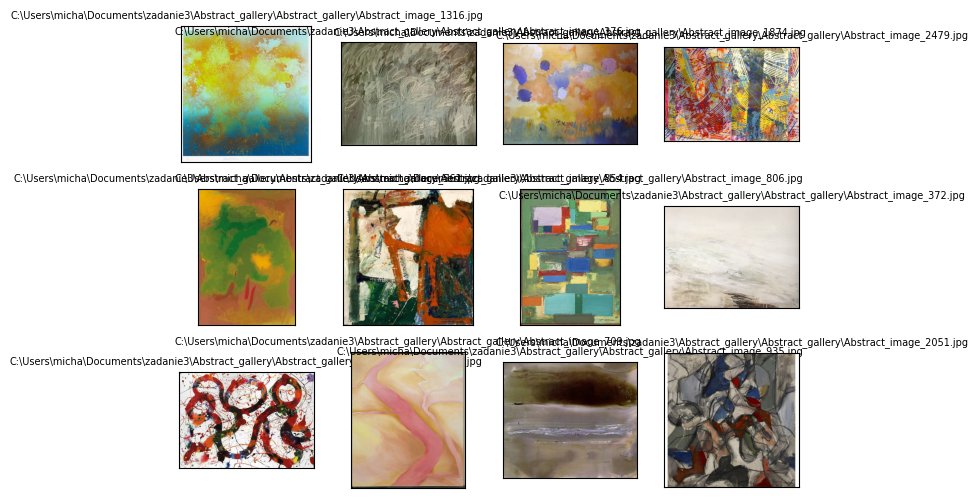

In [7]:
imagelab = Imagelab(data_path='./Abstract_gallery')
imagelab.visualize(num_images=12)

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|██████████| 2775/2775 [00:12<00:00, 228.56it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().
Issues found in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | odd_aspect_ratio |           26 |
|  1 | blurry           |           20 |
|  2 | dark             |           13 | 


Top 4 examples with odd_aspect_ratio issue in the dataset.


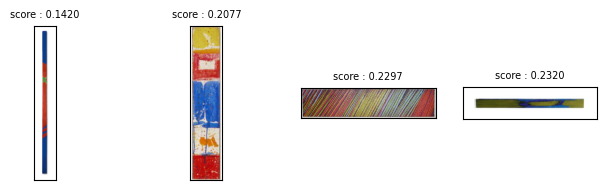


Top 4 examples with blurry issue in the dataset.


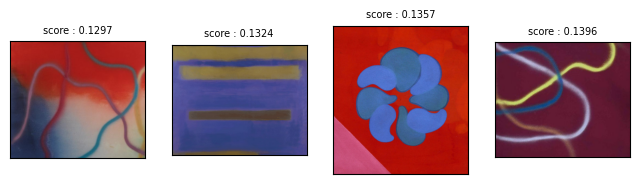


Top 4 examples with dark issue in the dataset.


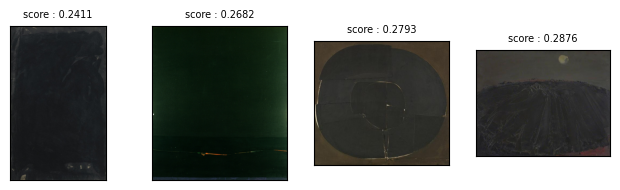

In [8]:
imagelab.find_issues()
imagelab.report()

Po prezretí problémov sme sa rozhodli odstrániť obrázky, ktoré boli exact a near duplicates.

In [9]:
for issue in ['exact_duplicates', 'near_duplicates']:
    l = list(imagelab.info[issue]['sets'])
    if len(l) == 0:
        print(f'No {issue} images were found')
        continue

    for i, ed in enumerate(l):
        print(f'\n{issue} set', i+1)
        print(ed[0])
        print(ed[1])
        os.remove(ed[1])

No exact_duplicates images were found
No near_duplicates images were found


In [10]:
# config
INPUT_DIM = 64
BATCH_SIZE = 16
EPOCHS = 500
NUM_EXAMPLES = 16

seed = tf.random.normal([NUM_EXAMPLES, INPUT_DIM, INPUT_DIM, 3])

Keďže boli obrázky rôzneho formátu a naša sieť vyžaduje rovnaké rozmery vstupných súborov, resizli sme ich na veľkosť 64x64 + spravili sme rescale pixelov na hodnoty z intervalu [0,1]. Následne sme načítali upravený dataset.

In [11]:
TARGET_SIZE = (INPUT_DIM, INPUT_DIM) 

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

image_data = datagen.flow_from_directory(
    './Abstract_gallery',
    target_size=TARGET_SIZE,
    class_mode=None, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,                 
)

Found 2775 images belonging to 1 classes.


In [12]:
def prepare_plt(batch):
    r = 4
    c = 4
    for i in range(BATCH_SIZE):
        plt.subplot(r, c , i+1)
        plt.imshow(batch[i, :, :, :])
        plt.axis('off')

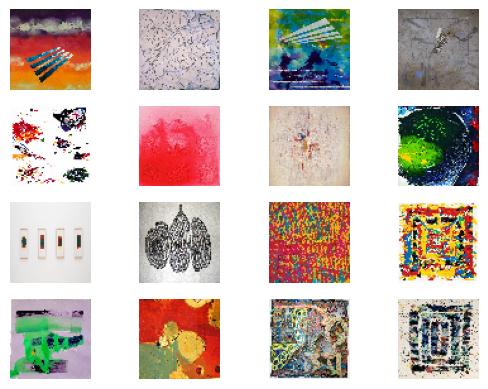

In [13]:
batch = image_data.next()
prepare_plt(batch)
plt.show()

# Architektúra
Architektúra sa skladá z dvoch sietí, generátora a diskriminátora. Pri ich tvorení sme sa inšpirovali viacerými výskumami + sú adaptované na našu konkrétnu problematiku. Náš pôvodný zámer bolo vyskúšať oba prístupy kombinované v jednom z článkov *TACKLING THE GENERATIVE LEARNING TRILEMMA WITH DENOISING DIFFUSION GANS* z roku 2022

## Generátor

Architektúra generátora je inšpirovaná zo spomínaného článku. V článku použili upravenú verziu Attention U-Net, detaily máme upravené podľa seba. Pri architektúre generátoru sme taktiež experimetovali s WeightNormalisation, ale pri použití implementácie z Tensorflow Addons nám tréning na kaggle spadol skrz zahltenie (nezávisle od veľkosti samotnej siete).

Architektúra je zostavená podobne ako na obrázku, s tým rozdielom, že namiesto ReLU používame LeakyReLU.

![GAN](attention_unet-compressed-2.jpg)<br>
<em>Architektúra Attention U-netu</em>

![GAN](attention_gate.png)<br>
<em>Použitý attention gate</em>



In [14]:
class DoubleConv(tf.keras.layers.Layer):
    def __init__(self, channels, kernel_size):
        super(DoubleConv, self).__init__()

        self.conv2d_1 = tf.keras.layers.Conv2D(filters=channels, kernel_size=kernel_size, padding='same')
        self.conv2d_2 = tf.keras.layers.Conv2D(filters=channels, kernel_size=kernel_size, padding='same')

        self.activation = tf.keras.layers.LeakyReLU()

    def call(self, inputs, training=None, mask=None):
        x = self.conv2d_1(inputs)
        x = self.activation(x)
        x = self.conv2d_2(x)
        x = self.activation(x)

        return  x


class Down(tf.keras.layers.Layer):
    def __init__(self, channels, kernel_size):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(channels, kernel_size)
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))

    def call(self, inputs, *args, **kwargs):
        x = self.double_conv(inputs)
        res = x
        x = self.pool(x)
        return res, x


class Up(tf.keras.layers.Layer):
    def __init__(self, channels, kernel_size):
        super(Up, self).__init__()
        self.up_sample = tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=kernel_size, strides = (2, 2), padding='same')
        self.double_conv = DoubleConv(channels, kernel_size)

    def call(self, inputs, *args, **kwargs):
        residual = inputs[0]
        x = inputs[1]

        x = self.up_sample(x)
        x = tf.concat([residual, x], axis=-1)

        x = self.double_conv(x)
        return x


class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()
        self.phi_g = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides = (1, 1), padding='same')
        self.theta_x = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(2, 2), padding='same')

        self.conv1x1 = tf.keras.layers.Conv2D(filters=1, kernel_size=(1,1), strides = (1, 1), padding='same')

        self.relu = tf.keras.layers.ReLU()

        self.upsampling = tf.keras.layers.UpSampling2D(size=(2,2))

    def call(self, inputs, *args, **kwargs):
        g = inputs[1]
        x = inputs[0]

        phi = self.phi_g(g)
        theta = self.theta_x(x)

        xg = tf.concat([phi, theta], axis=-1)

        xg = self.relu(xg)

        xg = self.conv1x1(xg)

        xg = tf.keras.activations.sigmoid(xg)

        upsampled = self.upsampling(xg)

        return tf.multiply(upsampled, x)


class UNet(tf.keras.models.Model):
    def __init__(self, no_layers, kernel_size=(3,3)):
        super(UNet, self).__init__()
        self.channels = [32,64,64,64,128]

        self.down = []
        self.up = []
        self.attention = []
        self.bottom = DoubleConv(self.channels[no_layers], kernel_size)

        offset = len(self.channels) - no_layers + 1

        for i in range(no_layers):
            self.down.append(Down(self.channels[i], kernel_size))
            self.up.append(Up(self.channels[-(i + offset)], kernel_size))
            self.attention.append(Attention())

        self.conv1x1 = tf.keras.layers.Conv2D(filters=3, kernel_size=(1,1), padding='same')

    def call(self, inputs, training=None, mask=None):
        x = inputs
        residuals = []

        for d in self.down:
            res, x = d(x)
            residuals.append(res)

        x = self.bottom(x)

        for i, u in enumerate(self.up):
            res_w_att = self.attention[i]([residuals[-(i + 1)],x])
            x = u([res_w_att, x])

        x = self.conv1x1(x)

        return x

## Diskriminátor

Architektúra diskriminátora je prevzatá z toho istého článku. Naša implementácia sa skladá zo:
- 2D vstupnej konvolučnej vrstvy,
- 2D Down konvolučných vrstiev, 
- Mini Batch Std vrsty *(vlastná implementácia, keďže ju Keras nemá)*,
- Global Sum Pooling vrstvy *(vlastná implementácia, keďže ju Keras nemá)*,
- a poslednej Fully conected vrstvy.

Použitá aktivačná funkcia - LeakyReLU.

In [15]:
class MinibatchStdDev(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-8, **kwargs):
        super(MinibatchStdDev, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs, *args, **kwargs):
        mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
        mean_sq_diff = tf.reduce_mean(tf.math.square(inputs - mean), axis=0, keepdims=True) + self.epsilon
        mean_pix = tf.reduce_mean(tf.math.sqrt(mean_sq_diff), keepdims=True)
        shape = tf.shape(inputs)
        output = tf.tile(mean_pix, [shape[0], shape[1], shape[2], 1])
        return tf.concat([inputs, output], axis=-1)

    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

In [16]:
class Discriminator(tf.keras.models.Model):
    def __init__(self, kernel_size=(3,3)):
        super(Discriminator, self).__init__()

        self.channels_down = [64,128,128,128]

        self.conv2d = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same')
        
        self.activation = tf.keras.layers.LeakyReLU(alpha=0.2)

        self.resNet = DoubleConv(64, kernel_size)
        self.resNet_down = []

        for channel in self.channels_down:
            self.resNet_down.append(Down(channel, kernel_size))

        self.pooling = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.minibatchStd = MinibatchStdDev()
        self.fc = tf.keras.layers.Dense(1)


    def call(self, inputs, training=None, mask=None):
        x = inputs
        x = self.conv2d(x)
        x = self.activation(x)

        res = x
        x = self.resNet(x)
        x = tf.add(res, x)

        for block in self.resNet_down:
            res, x = block(x)
            res = self.pooling(res)
            x = tf.add(res, x)
        
        x = self.minibatchStd(x)
    
        # global sum pooling
        x = tf.reduce_sum(x, axis=[1, 2])
        
        x = self.fc(x)

        return  x
    

## Sumarizácie vytvorených modelov

In [17]:
generator = UNet(4)
generator.build(input_shape=(None, INPUT_DIM, INPUT_DIM, 3))
generator.summary()

Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 down (Down)                 multiple                  10144     
                                                                 
 down_1 (Down)               multiple                  55424     
                                                                 
 down_2 (Down)               multiple                  73856     
                                                                 
 down_3 (Down)               multiple                  73856     
                                                                 
 up (Up)                     multiple                  184512    
                                                                 
 up_1 (Up)                   multiple                  147648    
                                                                 
 up_2 (Up)                   multiple                  147648

In [18]:
discriminator = Discriminator()
discriminator.build(input_shape=(None, INPUT_DIM, INPUT_DIM, 3))
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          multiple                  256       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   multiple                  0         
                                                                 
 double_conv_9 (DoubleConv)  multiple                  73856     
                                                                 
 down_4 (Down)               multiple                  73856     
                                                                 
 down_5 (Down)               multiple                  221440    
                                                                 
 down_6 (Down)               multiple                  295168    
                                                                 
 down_7 (Down)               multiple                

## Training process

Tréningový proces prebieha podľa state-of-the-art (ako znázorňuje obr. nižšie). Generátor je trénovaný každý piaty krok - to umožňuje generátoru vidieť pár krokov do "budúcnosti", čo by malo generátor motivovať k tomu, aby produkoval rozmanitejšie a realistickejšie vzorky, kedže dostane feedback zo silnejšieho discriminátora. Našu GAN sme trénovali na 500 epochách. Tréningový process bol priežne logovaný do WandB. [report](https://wandb.ai/xondovcikova/project3/runs/0ckft9yv)

![GAN](gan.png)<br>
<em>GAN training process</em>

**Loss funkcia:** Wasserestein loss + Gradient Penalty

**Optimizér:** Adam, hyperparamtre podľa článku *TACKLING THE GENERATIVE LEARNING TRILEMMA WITH DENOISING DIFFUSION GANS*

In [19]:
def wasserstein_loss(y_true, y_pred):    
    return tf.reduce_mean(y_true * y_pred)

In [20]:
def gradient_penalty(real_samples, fake_samples, batch_size):
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated_samples = alpha * real_samples + (1 - alpha) * fake_samples

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_samples)
        interpolated_predictions = discriminator(interpolated_samples)
        
    gradients = gp_tape.gradient(interpolated_predictions, interpolated_samples)
    l2_norm = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
    penalty_loss = tf.reduce_mean(tf.square(l2_norm - 1))
    
    return penalty_loss

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00016,
    beta_1=0.5,
    beta_2=0.9,
    epsilon=1e-4,
)

discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.5,
    beta_2=0.9,
    epsilon=1e-2,
)

In [22]:
def generate_and_save_images(model, test_input):
    predictions = model(test_input, training=False)
    prepare_plt(predictions)
    wandb.log({"generated_images":  plt}, commit=False)

Implementácia train_step a train funkcie inšpirovaná z [Tensorflow DCGAN tutorialu](https://www.tensorflow.org/tutorials/generative/dcgan)

In [23]:
def train_step(images, step, gen_loss, noise_train):
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise_train, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gp = gradient_penalty(images,generated_images,images.shape[0])
        real_loss = wasserstein_loss(tf.ones_like(real_output), real_output)
        fake_loss = wasserstein_loss(-tf.ones_like(fake_output), fake_output)

        # total discriminator loss
        disc_loss = real_loss + fake_loss + 10 * gp

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    if step % 5 == 0:
        with tf.GradientTape() as generator_tape:
            fake_samples = generator(noise_train)
            fake_predictions = discriminator(fake_samples)
            gen_loss = wasserstein_loss(tf.ones_like(fake_predictions), fake_predictions)

        generator_gradients = generator_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        gen_loss = 0

        for i, image_batch in enumerate(dataset):
            noise_train = tf.random.normal([image_batch.shape[0], INPUT_DIM, INPUT_DIM, 3])

            if i == image_data.__len__():
                break

            gen_loss, disc_loss = train_step(image_batch, i, gen_loss, noise_train)

        if epoch % 10 == 0:
            generate_and_save_images(generator, seed)
            generator.save(os.path.join(f'trained_model{epoch}', 'generator'))
            discriminator.save(os.path.join(f'trained_model{epoch}', 'discriminator'))

        wandb.log({"loss_generator": gen_loss, "loss_discriminator": disc_loss})
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # save last epoch
    generate_and_save_images(generator, seed)

In [ ]:
wandb.init(project="project3", entity="xondovcikova", config = {
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
})

train(image_data, EPOCHS)

![showcase](epoch670.png)<br>
<em>Ukážka vygenerovaných obrázkov po 670 epochách</em>

Z vygenerovaných obrázkov môžeme vidieť, že model zachytáva základne črty dát (napríklad biele plátno ako pozadie s abstrakntnými machuľami).